In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
import torch.optim as optim

from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
from torch.utils.data import DataLoader, Dataset  

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from skimage import io
#from PIL import Image

/home/joe/python/ai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [3]:
classes = pd.read_csv('images/class_dict.csv')

In [4]:
classes

,class_index,class,height,width,scale by,Offset
0,0,ABBOTTS BABBLER,112,112,1,0
1,1,ABBOTTS BOOBY,112,112,1,0
2,2,ABYSSINIAN GROUND HORNBILL,112,112,1,0
3,3,AFRICAN CROWNED CRANE,112,112,1,0
4,4,AFRICAN EMERALD CUCKOO,112,112,1,0
...,...,...,...,...,...,...
395,395,WILSONS BIRD OF PARADISE,112,112,1,0
396,396,WOOD DUCK,112,112,1,0
397,397,YELLOW BELLIED FLOWERPECKER,112,112,1,0
398,398,YELLOW CACIQUE,112,112,1,0


In [5]:
labels_birds = pd.read_csv('images/birds.csv')

In [6]:
class CustomDataset(Dataset):
    def __init__(self, csvFile, transform):
        self.data = csvFile
        self.img_dim = (112, 112)
        self.transform = transform       
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data['filepaths'].values[idx]
        class_id = self.data['class index'].values[idx]
        
        img = io.imread('images/'+img_path)
        class_id = torch.tensor(int(class_id))
        
        if self.transform:
            img_tensor = self.transform(img)
                    
        return (img_tensor, class_id)

In [7]:
#Function to show some random images
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

In [8]:
def split(dataset=None, train=0.7, test=0.2):
    num = len(dataset)
    train_set = int(len(dataset) * train)
    test_set = int(len(dataset) * test)
    valid_set = num - train_set - test_set
    return [train_set, test_set, valid_set]
    

In [9]:
# load data
dataset  = CustomDataset(labels_birds, transform)

train_set, test_set, valid_set = torch.utils.data.random_split(dataset, split(dataset))

In [10]:
trainloader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
testloader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)
validloader = DataLoader(dataset=valid_set, batch_size=32, shuffle=True)

In [11]:
#Get some random training images
dataiter = iter(trainloader)
imgAndLabel = dataiter.next()

CRESTED CARACARA


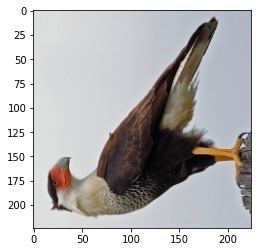

MOURNING DOVE


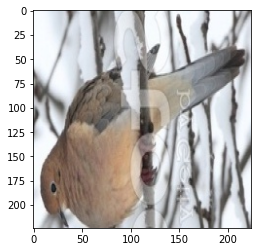

CAPE GLOSSY STARLING


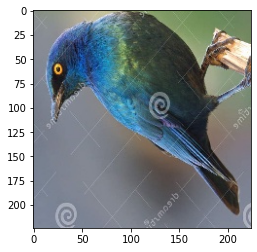

GOLD WING WARBLER


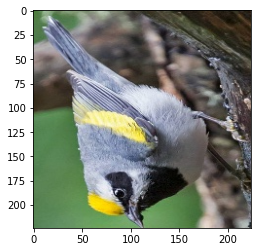

SATYR TRAGOPAN


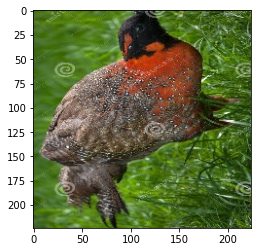

In [12]:

for i in range(5):
    print(classes['class'].loc[classes['class_index']==int(imgAndLabel[1][i])].values[0])
    imshow(imgAndLabel[0][int(i)].T)
    

In [13]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Using cache found in /home/joe/.cache/torch/hub/pytorch_vision_v0.6.0


In [14]:
#Model description
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
#Updating the second classifier
AlexNet_model.classifier[4] = nn.Linear(4096,1024)

In [16]:
#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[6] = nn.Linear(1024,len(classes))

In [17]:
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Verifying CUDA
print(device)

cuda:0


In [19]:
#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
#Loss
criterion = nn.CrossEntropyLoss()

In [21]:
#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [22]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

Finished Training of AlexNet


In [23]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [28]:
classes['class']

0                  ABBOTTS BABBLER
1                    ABBOTTS BOOBY
2       ABYSSINIAN GROUND HORNBILL
3            AFRICAN CROWNED CRANE
4           AFRICAN EMERALD CUCKOO
                  ...             
395       WILSONS BIRD OF PARADISE
396                      WOOD DUCK
397    YELLOW BELLIED FLOWERPECKER
398                 YELLOW CACIQUE
399        YELLOW HEADED BLACKBIRD
Name: class, Length: 400, dtype: object

In [30]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
            classes['class'].loc[classes['class_index']==i], 100 * class_correct[i] / class_total[i]))


Accuracy of 0    ABBOTTS BABBLER
Name: class, dtype: object : 100 %
Accuracy of 1    ABBOTTS BOOBY
Name: class, dtype: object : 60 %
Accuracy of 2    ABYSSINIAN GROUND HORNBILL
Name: class, dtype: object : 60 %
Accuracy of 3    AFRICAN CROWNED CRANE
Name: class, dtype: object : 100 %
Accuracy of 4    AFRICAN EMERALD CUCKOO
Name: class, dtype: object : 100 %
Accuracy of 5    AFRICAN FIREFINCH
Name: class, dtype: object : 85 %
Accuracy of 6    AFRICAN OYSTER CATCHER
Name: class, dtype: object : 100 %
Accuracy of 7    ALBATROSS
Name: class, dtype: object : 75 %
Accuracy of 8    ALBERTS TOWHEE
Name: class, dtype: object : 66 %
Accuracy of 9    ALEXANDRINE PARAKEET
Name: class, dtype: object : 100 %
Accuracy of 10    ALPINE CHOUGH
Name: class, dtype: object : 83 %
Accuracy of 11    ALTAMIRA YELLOWTHROAT
Name: class, dtype: object : 83 %
Accuracy of 12    AMERICAN AVOCET
Name: class, dtype: object : 75 %
Accuracy of 13    AMERICAN BITTERN
Name: class, dtype: object : 100 %
Accuracy of 14    

ZeroDivisionError: float division by zero

In [38]:
avg = 0
for i in range(len(classes)):
  temp = (100 * (class_correct[i]+1) / (class_total[i]+1))
  avg = avg + temp
avg = avg/len(classes)
print('Average accuracy = ', avg)

Average accuracy =  90.08411796536798
